**Fonte**: https://www.kaggle.com/luisfredgs/imdb-ptbr


In [98]:
import pandas as pd
import sklearn.model_selection as ms
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
import unidecode
import nltk
from nltk import tokenize
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
%matplotlib inline

In [4]:
df_data = pd.read_csv('../data/imdb-reviews-pt-br.csv.zip')
df_data = df_data.sample(100)
df_data.sample()


,id,text_en,text_pt,sentiment
30294,30296,And that is the only reason I posses this DVD....,E essa é a única razão pela qual eu possuo est...,neg


In [5]:
df_data["sentiment"].value_counts(normalize=True)


pos    0.61
neg    0.39
Name: sentiment, dtype: float64

In [6]:
df_data["sentiment_int"] = df_data["sentiment"].replace({"pos": 1, "neg": 0})
df_data.sample(5)

,id,text_en,text_pt,sentiment,sentiment_int
26254,26256,It is not obvious from viewing this film so I ...,"Não é óbvio ao ver este filme, por isso recome...",neg,0
4706,4708,Jefferey dahmer was one sick guy. Theres not m...,Jefferey Dahmer era um cara doente. Não há mui...,neg,0
39230,39232,One of Disneys best films that I can enjoy wat...,Um dos melhores filmes da Disney que eu gosto ...,pos,1
37047,37049,Picked this up for 50 cents at the flea market...,Escolhi isso por 50 centavos no mercado de pul...,neg,0
24289,24291,Big Fat Liar is the best movie ever! It is fun...,Big Fat Liar é o melhor filme de todos os temp...,pos,1


# Bag of words

In [7]:
# CountVector
vectorization = CountVectorizer(lowercase=False, max_features=50)
bag_of_words = vectorization.fit_transform(df_data["text_pt"])
bag_of_words.shape


(100, 50)

In [8]:
train, test, y_train, y_test = ms.train_test_split(
    bag_of_words, df_data["sentiment_int"], random_state=42)


In [9]:
reg = LogisticRegression()
reg.fit(train, y_train)
acuracy = reg.score(test, y_test)
print(acuracy)


0.68


In [10]:
def classification_text(df, column_text, column_sentiment):
    vectorization = CountVectorizer(lowercase=False, max_features=50)
    bag_of_words = vectorization.fit_transform(df[column_text])
    train, test, y_train, y_test = ms.train_test_split(
        bag_of_words, df[column_sentiment], random_state=42)
    reg = LogisticRegression()
    reg.fit(train, y_train)
    acuracy = reg.score(test, y_test)
    return acuracy


In [11]:
classification_text(df_data, "text_pt", "sentiment_int")

0.68

In [12]:
all_words = ' '.join([text for text in df_data["text_pt"]])

In [13]:
def plot_word_cloud(text, title):
    word_cloud = WordCloud(
        width=800,
        height=500,
        max_font_size=110,
        collocations=False
    ).generate(text)
    plt.figure(figsize=(10, 7))
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.title(title, fontdict={"fontsize": 24, "color": "white"})
    plt.axis("off")
    plt.show()
    plt.close()


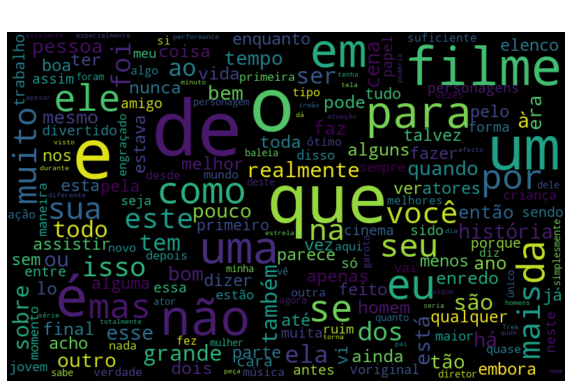

In [14]:
plot_word_cloud(all_words, "All words")


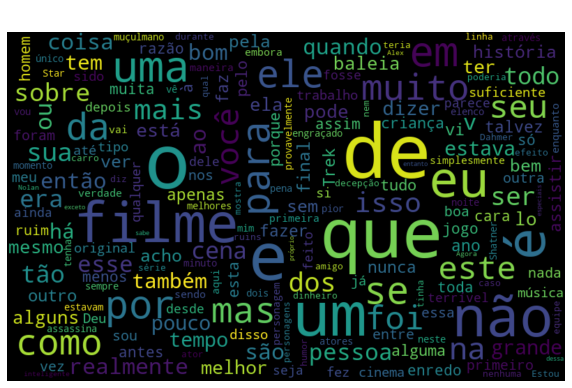

In [15]:
all_words_neg = ' '.join(
    [text for text in df_data.loc[df_data["sentiment_int"]==0]["text_pt"]])
plot_word_cloud(all_words_neg, "Negative words")


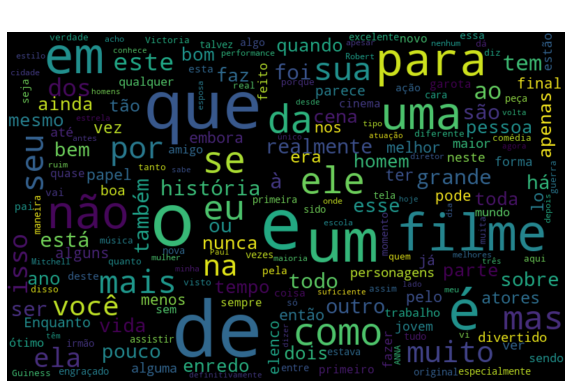

In [16]:
all_words_pos = ' '.join(
    [text for text in df_data.loc[df_data["sentiment_int"] == 1]["text_pt"]])
plot_word_cloud(all_words_pos, "Positive words")


In [17]:
tokenize_whitespace = tokenize.WhitespaceTokenizer()
tokenize_all_words = tokenize_whitespace.tokenize(all_words)
freq = nltk.FreqDist(tokenize_all_words)

In [18]:
df_freq = pd.DataFrame({"word":freq.keys(), "freq":freq.values()})
df_freq.nlargest(columns="freq", n=10)


,word,freq
90,de,837
23,e,663
13,que,659
36,o,526
3,um,506
9,a,476
106,é,382
62,em,297
15,não,290
44,para,262


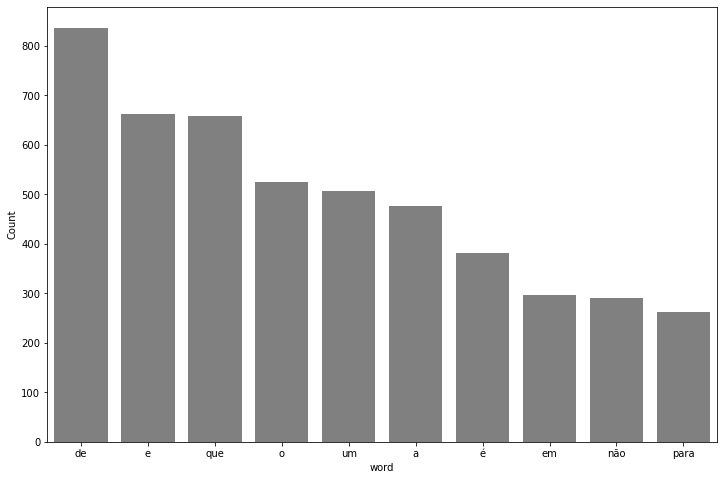

In [19]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=df_freq.nlargest(columns="freq", n=10),
    x="word",
    y="freq",
    color="gray"
)
ax.set(ylabel="Count")
plt.show()


In [20]:
def plot_freq_dist(df, column_filter, title, n=10):
    analyzed_words = ' '.join(
        [text for text in df[column_filter]]
    )

    tokenize_whitespace = tokenize.WhitespaceTokenizer()
    tokenize_all_words = tokenize_whitespace.tokenize(analyzed_words)
    freq = nltk.FreqDist(tokenize_all_words)
    df_freq = pd.DataFrame({"word": freq.keys(), "freq": freq.values()})
    df_freq = df_freq.nlargest(columns="freq", n=n)
    df_freq["freq_normalize_accumulated"] = (
        100 * df_freq["freq"].cumsum()/df_freq["freq"].sum())

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        data=df_freq,
        x="word",
        y="freq",
        color="gray"
    )
    ax2 = ax.twinx()
    sns.lineplot(data=df_freq, x='word', y='freq_normalize_accumulated',
                 color='red', sort=False, ax=ax2)
    ax.set(ylabel="Count")
    plt.title(title, fontdict={"fontsize": 24, "color": "white"})
    plt.show()
    plt.close()


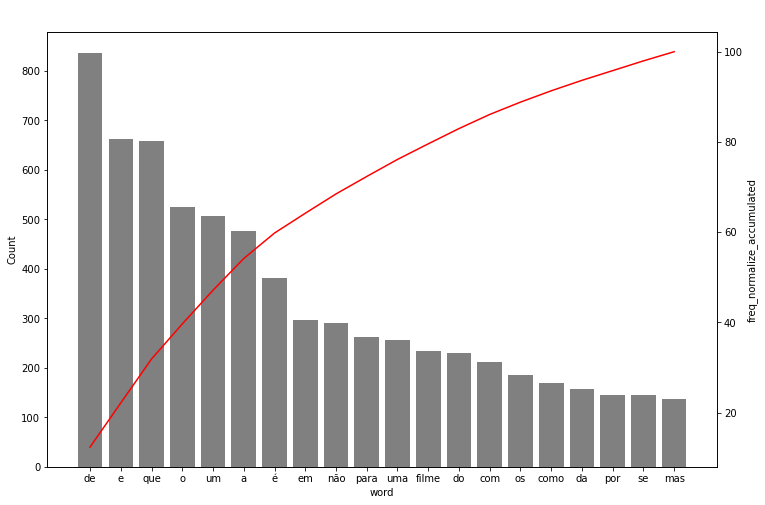

In [21]:
plot_freq_dist(df_data,  "text_pt", "All words", n=20)


In [22]:
def remove_accents(text):
    return unidecode.unidecode(text)

In [59]:
def remove_stop_words(text):
    stop_words = list(
        dict.fromkeys(
            nltk.corpus.stopwords.words("portuguese") +
            [remove_accents(word) for word in nltk.corpus.stopwords.words("portuguese")]
        )
    )
    tokenize_whitespace = tokenize.WhitespaceTokenizer()
    tokenize_all_words = tokenize_whitespace.tokenize(text)
    return " ".join([word for word in tokenize_all_words if word not in stop_words])


In [60]:
def remove_punctuation(text):
    tokenize_punctuation = tokenize.WordPunctTokenizer()
    tokenize_all_words = tokenize_punctuation.tokenize(text)
    return " ".join([word for word in tokenize_all_words if word not in punctuation])
   

In [84]:
stemmer = nltk.stem.RSLPStemmer()

def stemming(text):
    tokenize_whitespace = tokenize.WhitespaceTokenizer()
    tokenize_all_words = tokenize_whitespace.tokenize(text)
    return " ".join([stemmer.stem(word) for word in tokenize_all_words])

In [92]:
df_data["text_processed"] = df_data["text_pt"].apply(remove_accents).str.lower()
df_data["text_processed"] = df_data["text_processed"].apply(remove_stop_words)
df_data["text_processed"] = df_data["text_processed"].apply(remove_punctuation)
df_data["text_processed"] = df_data["text_processed"].apply(stemming)
df_data.head(10)


,id,text_en,text_pt,sentiment,sentiment_int,text_processed
4706,4708,Jefferey dahmer was one sick guy. Theres not m...,Jefferey Dahmer era um cara doente. Não há mui...,neg,0,jefferey dahm car doent diz sobr sid dit excet...
11445,11447,"people, get a clue! I mean, the writers dont h...","pessoas, tenha uma pista! Quero dizer, os escr...",neg,0,pesso pist quer diz escri um enta esper ... sh...
13011,13013,The chemistry between Sally Hawkins and Elaine...,A química entre Sally Hawkins e Elaine Cassidy...,pos,1,quim sally hawkim elain cassidy incri complet ...
12602,12604,Scientist Carl Lehman well played by David McI...,"O cientista Carl Lehman, interpretado por Davi...",pos,1,cient carl lehman interpret david mcilwraith e...
21561,21563,This has one of the more unusual plots Ive see...,Isso tem um dos enredos mais incomuns que eu j...,pos,1,enred incomum vi film terr base bom sol recurs...
37498,37500,"Delightful minor film, juggling comedy and det...","Delicioso filme menor, fazendo malabarismos co...",pos,1,delici film men faz malabar gener comed deteti...
21938,21940,Dont Look In the Basement is so easy to knock ...,Dont Look In the Basement é tão fácil de bater...,pos,1,dont look in the basement tao facil bat verdad...
28621,28623,"Well, I hate hollywood, but love cinema so i h...","Bem, eu odeio Hollywood, mas amo cinema, então...",neg,0,bem odei hollywood amo cinem enta assist film ...
44634,44636,This is my kind of film. I am fascinated by st...,Este é o meu tipo de filme. Eu sou fascinado p...,pos,1,tip film fascin estranh pesadel psico film ape...
19173,19175,before watching this movie my thoughts were li...,antes de assistir a este filme meus pensamento...,pos,1,"ant assist film pens outr film tipic israel "",..."


In [93]:
classification_text(df_data, "text_processed", "sentiment_int")


0.6

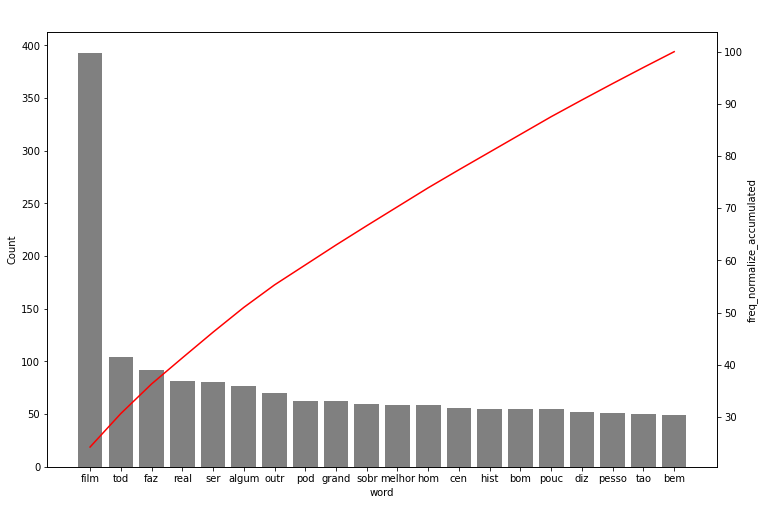

In [94]:
plot_freq_dist(df_data,  "text_processed", "All words processed", n=20)


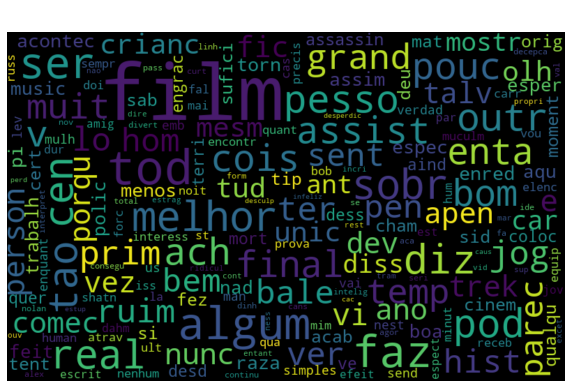

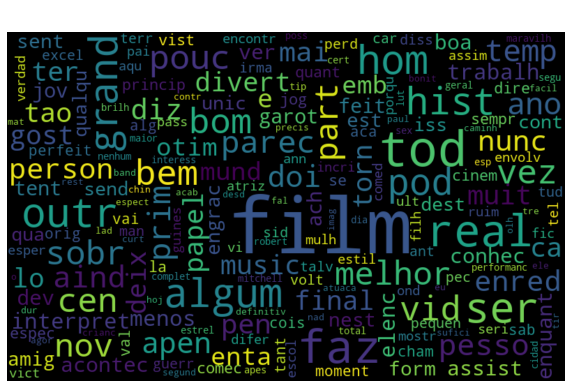

In [95]:
all_words_neg = ' '.join(
    [text for text in df_data.loc[df_data["sentiment_int"] == 0]["text_processed"]])
plot_word_cloud(all_words_neg, "Negative words")

all_words_pos = ' '.join(
    [text for text in df_data.loc[df_data["sentiment_int"] == 1]["text_processed"]])
plot_word_cloud(all_words_pos, "Positive words")

In [96]:
tfidf = TfidfVectorizer(lowercase=False, max_features=50)
tfidf_words = tfidf.fit_transform(df_data["text_pt"])
train, test, y_train, y_test = ms.train_test_split(tfidf_words, df_data["sentiment_int"], random_state=42)
reg.fit(train, y_train)
acuracy = reg.score(test, y_test)
acuracy

0.76

In [97]:
tfidf = TfidfVectorizer(lowercase=False, max_features=50)
tfidf_words = tfidf.fit_transform(df_data["text_processed"])
train, test, y_train, y_test = ms.train_test_split(
    tfidf_words, df_data["sentiment_int"], random_state=42)
reg.fit(train, y_train)
acuracy = reg.score(test, y_test)
acuracy


0.8

In [101]:

tfidf = TfidfVectorizer(lowercase=False, ngram_range=(1, 2))
tfidf_words = tfidf.fit_transform(df_data["text_processed"])
train, test, y_train, y_test = ms.train_test_split(
    tfidf_words, df_data["sentiment_int"], random_state=42)
reg.fit(train, y_train)
acuracy = reg.score(test, y_test)
acuracy


0.72

In [105]:
weigh_word = pd.DataFrame(reg.coef_[0].T, index=tfidf.get_feature_names_out())
weigh_word.nlargest(10,0)


,0
garot,0.192697
papel,0.184600
difer,0.175480
otim,0.166441
vid,0.166077
atriz,0.160811
mund,0.157194
part,0.144576
gost,0.141156
nov,0.140699


In [106]:
weigh_word.nsmallest(10,0)

,0
vs,-0.297539
bale,-0.228025
crianc,-0.203352
raza,-0.183891
ach,-0.180079
vou,-0.167752
diz,-0.167130
cois,-0.162906
trek,-0.160230
melhor,-0.156138
